#Binary AskQE Extension  
Pipeline: Template(OpenIE/Dependency/NER) + SRL + Word Diff + Atomic

#Git

In [ ]:
!git config --global user.email ""
!git config --global user.name ""

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/Binary_extention.ipynb' /content/askqe/

In [ ]:
!git reset --soft HEAD~1

In [ ]:
!git reset HEAD

Unstaged changes after reset:
M	Binary_extention.ipynb
M	QA/code/__pycache__/prompt.cpython-312.pyc
M	QG/code/__pycache__/prompt.cpython-312.pyc
D	askqe_atomic_facts_filtered.jsonl
M	biomqm/askqe/__pycache__/prompt.cpython-312.pyc
M	evaluation/string-comparison/__pycache__/utils.cpython-312.pyc


In [ ]:
!git add .

In [ ]:
!git commit -m "Implement LLM-based SRL, word diff, and atomic fact extraction"

[main a42a30c] Implement LLM-based SRL, word diff, and atomic fact extraction
 10 files changed, 18586 insertions(+), 1 deletion(-)
 rename askqe_atomic_facts_filtered.jsonl => binary_extension_results/askqe_atomic_facts_filtered.jsonl (100%)
 create mode 100644 binary_extension_results/atomic_facts_extracted.json
 create mode 100644 binary_extension_results/binary_extension_results.json
 create mode 100644 binary_extension_results/extension_summary.csv
 create mode 100644 binary_extension_results/results_visualization.png


In [ ]:
!git remote set-url origin https://@github.com/erythm/askqe.git
!git push origin main

Enumerating objects: 38, done.
Counting objects: 100% (38/38), done.
Delta compression using up to 12 threads
Compressing objects: 100% (23/23), done.
Writing objects: 100% (24/24), 677.09 KiB | 7.78 MiB/s, done.
Total 24 (delta 10), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (10/10), completed with 9 local objects.
To https://github.com/erythm/askqe.git
   8c8533a..a42a30c  main -> main


# 1. Requirments

In [ ]:
from huggingface_hub import login
login("")

In [ ]:
!git clone https://github.com/erythm/askqe.git

Cloning into 'askqe'...
remote: Enumerating objects: 1191, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 1191 (delta 47), reused 59 (delta 27), pack-reused 1102 (from 2)
Receiving objects: 100% (1191/1191), 54.52 MiB | 9.06 MiB/s, done.
Resolving deltas: 100% (919/919), done.


In [ ]:
%cd askqe

/content/askqe


In [ ]:
%cd ..

/content


In [ ]:
!pip install -q vllm transformers accelerate sacrebleu
!pip install -q spacy
!python -m spacy download en_core_web_sm

print("Libraries installed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.9/474.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.0/355.0 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/

In [ ]:
import json
import os
import re
import ast
import pandas as pd
import numpy as np
from scipy.stats import kendalltau, spearmanr, pearsonr
from tqdm import tqdm

print("Imports done!")

Imports done!


#2. Repository Imports

In [ ]:
import sys
import importlib.util

REPO_PATH = "askqe"

# Add repository paths to Python path
sys.path.insert(0, REPO_PATH)
sys.path.insert(0, f"{REPO_PATH}/QG/code")
sys.path.insert(0, f"{REPO_PATH}/QA/code")
sys.path.insert(0, f"{REPO_PATH}/biomqm/askqe")
sys.path.insert(0, f"{REPO_PATH}/evaluation/string-comparison")

# --- Import Prompts from Repository ---
from QG.code.prompt import nli as qg_nli_prompt
from QG.code.prompt import vanilla as qg_vanilla_prompt
from QA.code.prompt import qa_prompt
from biomqm.askqe.prompt import atomic_fact_prompt

# --- Import utils using importlib ---
utils_path = f"{REPO_PATH}/evaluation/string-comparison/utils.py"
spec = importlib.util.spec_from_file_location("utils_module", utils_path)
utils_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils_module)

# Assign scoring functions (for comparison with baseline)
repo_f1_score = utils_module.f1_score
repo_exact_match_score = utils_module.exact_match_score
normalize_answer = utils_module.normalize_answer

print("Repository imports loaded!")
print(f"   - Prompts: atomic_fact_prompt, qg_nli_prompt, qa_prompt")
print(f"   - Scoring: f1_score, exact_match_score")

# Store templates
atomic_fact_prompt_template = atomic_fact_prompt
qg_prompt_template = qg_nli_prompt
qa_prompt_template = qa_prompt

Repository imports loaded!
   - Prompts: atomic_fact_prompt, qg_nli_prompt, qa_prompt
   - Scoring: f1_score, exact_match_score


#3. Load Qwen2.5-7B Model with vLLM (GPU: L4)

In [ ]:
from vllm import LLM, SamplingParams

MODEL_ID = "Qwen/Qwen2.5-7B-Instruct-AWQ"

print(f"Loading {MODEL_ID}...")

llm = LLM(
    model=MODEL_ID,
    quantization="awq",
    dtype="half",
    max_model_len=2048,
    gpu_memory_utilization=0.80,
    seed=42,
    enable_prefix_caching=True,
    disable_log_stats=True,
)

SAMPLING_PARAMS = SamplingParams(
    temperature=0,
    max_tokens=1024,
)

print(f"LLM loaded: {MODEL_ID}")

Loading Qwen/Qwen2.5-7B-Instruct-AWQ...
INFO 12-30 17:46:55 [utils.py:253] non-default args: {'dtype': 'half', 'seed': 42, 'max_model_len': 2048, 'enable_prefix_caching': True, 'gpu_memory_utilization': 0.8, 'disable_log_stats': True, 'quantization': 'awq', 'model': 'Qwen/Qwen2.5-7B-Instruct-AWQ'}
INFO 12-30 17:46:56 [model.py:514] Resolved architecture: Qwen2ForCausalLM
INFO 12-30 17:46:56 [model.py:1661] Using max model len 2048
INFO 12-30 17:46:57 [awq_marlin.py:166] Detected that the model can run with awq_marlin, however you specified quantization=awq explicitly, so forcing awq. Use quantization=awq_marlin for faster inference
INFO 12-30 17:47:00 [scheduler.py:230] Chunked prefill is enabled with max_num_batched_tokens=8192.


Parse safetensors files:   0%|          | 0/2 [00:00<?, ?it/s]

WARNING 12-30 17:47:02 [system_utils.py:136] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 12-30 17:47:59 [llm.py:360] Supported tasks: ['generate']
LLM loaded: Qwen/Qwen2.5-7B-Instruct-AWQ


#4. Helper functions

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)


def generate_text_batch(prompts, sampling_params=SAMPLING_PARAMS):
    """Generate text for multiple prompts using chat template."""
    formatted_prompts = []
    for p in prompts:
        messages = [{"role": "user", "content": p}]
        formatted = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        formatted_prompts.append(formatted)

    outputs = llm.generate(formatted_prompts, sampling_params)

    generated_texts = []
    for output in outputs:
        text = output.outputs[0].text.strip()
        generated_texts.append(text)

    return generated_texts


def parse_list_output(text):
    """Parse a string representation of a list into a Python list."""
    try:
        # Clean up
        text = text.strip()

        # Find list boundaries
        start = text.find('[')
        end = text.rfind(']') + 1

        if start != -1 and end > start:
            candidate = text[start:end]
            return ast.literal_eval(candidate)
        return []
    except:
        return []


# Test
test_output = generate_text_batch(["Say 'Hello World' and nothing else."])
print(f"Test output: {test_output[0]}")
print("LLM helper functions ready!")

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Test output: Hello World
LLM helper functions ready!


#5. Data

##5.1 Load data

In [ ]:
LIMIT = None  # None = all data


# MQM Score Calculation
def calculate_mqm_score(errors):
    """Calculate MQM score from errors list.
    Formula: 100 - (Minor*1 + Major*5 + Critical*25)
    """
    weights = {"Minor": 1, "Major": 5, "Critical": 25}
    score_penalty = 0
    for error in errors:
        severity = error.get("severity")
        score_penalty += weights.get(severity, 0)
    return max(0, 100 - score_penalty)


def get_max_severity(errors):
    """Get maximum severity from errors list."""
    if not errors:
        return "No Error"
    severities = [e.get("severity") for e in errors if e]
    if "Critical" in severities:
        return "Critical"
    if "Major" in severities:
        return "Major"
    if "Minor" in severities:
        return "Minor"
    return "No Error"



# Load BIOMQM Data
def load_biomqm_data(file_path, limit=None):
    """Load BIOMQM dataset - same structure as baseline."""
    data_entries = []

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if limit and i >= limit:
                    break
                item = json.loads(line)

                entry = {
                    'id': item.get('doc_id', f'doc_{i}'),
                    'source': item['src'],
                    'target': item['tgt'],  # German translation
                    'backtranslation': item.get('bt_tgt', ''),
                    'errors': item.get('errors_tgt', []),
                    'mqm_score': calculate_mqm_score(item.get('errors_tgt', [])),
                    'severity': get_max_severity(item.get('errors_tgt', []))
                }
                data_entries.append(entry)

        print(f"✅ Loaded {len(data_entries)} entries from BIOMQM")
        return data_entries

    except FileNotFoundError:
        print(f"❌ Error: File {file_path} not found.")
        return []

##5.2 Data Cleaning

In [ ]:
def term_in_data(dataset):
    """Remove rows where error term is not in source/target.
    This cleans invalid error annotations.
    """
    valid_rows = []
    removed_count = 0

    for row in dataset:
        tgt = row.get('target', '')
        src = row.get('source', '')
        errors = row.get('errors', [])
        is_row_clean = True

        for error in errors:
            term = error.get('term', '')
            if term:
                # Check if error term exists in source or target
                if term not in tgt and term not in src:
                    is_row_clean = False
                    break

        if is_row_clean:
            valid_rows.append(row)
        else:
            removed_count += 1

    print(f"   Removed {removed_count} rows with invalid error terms")
    return valid_rows

# LOAD AND CLEAN DATA
BIOMQM_FILE = f"{REPO_PATH}/biomqm/dev_with_backtranslation.jsonl"

print("📂 Loading BIOMQM dataset...")
dataset_raw = load_biomqm_data(BIOMQM_FILE, limit=LIMIT)

print("\nCleaning data...")
dataset = term_in_data(dataset_raw)
print(f"Clean dataset: {len(dataset)} samples")

📂 Loading BIOMQM dataset...
✅ Loaded 5216 entries from BIOMQM

Cleaning data...
   Removed 216 rows with invalid error terms
Clean dataset: 5000 samples


##5.3 Statistics

In [ ]:
df_preview = pd.DataFrame(dataset)

print(f"\n" + "="*50)
print("📊 DATASET STATISTICS")
print("="*50)

print(f"\n📊 Severity Distribution:")
print(df_preview["severity"].value_counts().to_string())

print(f"\n📊 MQM Score Statistics:")
print(f"   Min: {df_preview['mqm_score'].min()}")
print(f"   Max: {df_preview['mqm_score'].max()}")
print(f"   Mean: {df_preview['mqm_score'].mean():.2f}")

print(f"\n📊 MQM Score by Severity:")
for sev in ["No Error", "Minor", "Major", "Critical"]:
    sev_data = df_preview[df_preview["severity"] == sev]["mqm_score"]
    if len(sev_data) > 0:
        print(f"   {sev:12s}: mean={sev_data.mean():.1f}, count={len(sev_data)}")

# Example
print(f"\n Example Entry:")
ex = dataset[0]
print(f"   ID: {ex['id']}")
print(f"   Source: {ex['source'][:70]}...")
print(f"   Target: {ex['target'][:70]}...")
print(f"   BT: {ex['backtranslation'][:70]}...")
print(f"   Severity: {ex['severity']}")
print(f"   MQM Score: {ex['mqm_score']}")
print(f"   Errors: {ex['errors'][:2] if ex['errors'] else 'None'}...")


📊 DATASET STATISTICS

📊 Severity Distribution:
severity
No Error    2037
Minor       1803
Major       1049
Critical     111

📊 MQM Score Statistics:
   Min: 23
   Max: 100
   Mean: 96.85

📊 MQM Score by Severity:
   No Error    : mean=100.0, count=2037
   Minor       : mean=98.4, count=1803
   Major       : mean=90.9, count=1049
   Critical    : mean=70.5, count=111

 Example Entry:
   ID: doc11
   Source: Three cases of cervicofacial NF are presented in this case report....
   Target: In diesem Fallbericht werden drei Fälle von zervikofazialem NF vorgest...
   BT: This case report presents three cases of cervicofacial NF....
   Severity: Major
   MQM Score: 95
   Errors: [{'term': 'zervikofazialem', 'startIndex': 44, 'endIndex': 58, 'error_category': 'Linguistic_conventions', 'error_subcategory': 'Grammar', 'severity': 'Major'}]...


#6. Feature Extraction

##6.1 Load spaCy

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

print("spaCy loaded!")

spaCy loaded!


##6.2 spaCy Feature Extraction
Negations, Numbers, Dates, Entities, Verbs

In [ ]:
def extract_negations(doc):
    """Extract negations with their scope."""
    negations = []
    for token in doc:
        if token.dep_ == "neg":
            head = token.head
            negations.append({
                "negation": token.text,
                "negated_word": head.lemma_,
                "verb": head.text
            })
    return negations


def extract_numbers(doc):
    """Extract numbers with context."""
    numbers = []
    seen = set()

    for token in doc:
        if token.pos_ == "NUM":
            value = token.text.strip()
            context = None

            if token.dep_ == "nummod" and token.head.pos_ in ("NOUN", "PROPN"):
                context = token.head.text
            elif token.head.pos_ in ("NOUN", "PROPN"):
                context = token.head.text
            else:
                for child in token.head.children:
                    if child.pos_ in ("NOUN", "PROPN"):
                        context = child.text
                        break

            key = (value, context)
            if key not in seen and value:
                seen.add(key)
                numbers.append({"value": value, "context": context})

    return numbers


def extract_dates(doc):
    """Extract date/time/quantity entities."""
    dates = []
    seen = set()

    for ent in doc.ents:
        if ent.label_ in ("DATE", "TIME", "PERCENT", "MONEY", "QUANTITY", "CARDINAL", "ORDINAL"):
            if ent.text not in seen:
                seen.add(ent.text)
                dates.append({"text": ent.text, "label": ent.label_})

    return dates


def extract_entities(doc):
    """Extract important named entities."""
    entities = []
    seen = set()
    important_labels = {"PERSON", "ORG", "GPE", "PRODUCT", "EVENT", "WORK_OF_ART", "LAW"}

    for ent in doc.ents:
        if ent.label_ in important_labels:
            if ent.text.lower() not in seen and len(ent.text) > 2:
                seen.add(ent.text.lower())
                entities.append({"text": ent.text, "label": ent.label_})

    return entities


def extract_main_verbs(doc):
    """Extract main verbs with subject/object."""
    verbs = []

    for token in doc:
        if token.pos_ == "VERB" and token.dep_ in ("ROOT", "relcl", "advcl"):
            verb_info = {
                "verb": token.lemma_,
                "verb_text": token.text,
                "subject": None,
                "object": None
            }

            for child in token.children:
                if child.dep_ in ("nsubj", "nsubjpass"):
                    subj_tokens = [t.text for t in child.subtree]
                    if len(subj_tokens) <= 5:
                        verb_info["subject"] = " ".join(subj_tokens)

                elif child.dep_ in ("dobj", "obj", "attr"):
                    obj_tokens = [t.text for t in child.subtree]
                    if len(obj_tokens) <= 5:
                        verb_info["object"] = " ".join(obj_tokens)

            if verb_info["subject"] or verb_info["object"]:
                verbs.append(verb_info)

    return verbs


def extract_spacy_features(text):
    """Extract all spaCy-based features from text."""
    doc = nlp(text)
    return {
        "negations": extract_negations(doc),
        "numbers": extract_numbers(doc),
        "dates": extract_dates(doc),
        "entities": extract_entities(doc),
        "verbs": extract_main_verbs(doc)
    }


# Test
test_text = "Dr. Smith did not give the patient 5mg of morphine on Monday."
features = extract_spacy_features(test_text)
print(f"Text: {test_text}")
print(f"   Negations: {features['negations']}")
print(f"   Numbers: {features['numbers']}")
print(f"   Dates: {features['dates']}")
print(f"   Entities: {features['entities']}")
print(f"   Verbs: {features['verbs']}")
print("spaCy feature extraction ready!")

Text: Dr. Smith did not give the patient 5mg of morphine on Monday.
   Negations: [{'negation': 'not', 'negated_word': 'give', 'verb': 'give'}]
   Numbers: [{'value': '5', 'context': 'mg'}]
   Dates: [{'text': '5', 'label': 'CARDINAL'}, {'text': 'Monday', 'label': 'DATE'}]
   Entities: [{'text': 'Smith', 'label': 'PERSON'}]
   Verbs: [{'verb': 'give', 'verb_text': 'give', 'subject': 'Dr. Smith', 'object': None}]
spaCy feature extraction ready!


##6.3 LLM-based SRL (Semantic Role Labeling)
agent, patient, time, location, negation

In [ ]:
SRL_PROMPT = """Extract semantic roles from this sentence. Return ONLY a JSON object.

Sentence: "{sentence}"

Extract:
- verb: main action verb
- agent: who performs the action (ARG0)
- patient: what/who is affected (ARG1)
- time: when (if mentioned)
- location: where (if mentioned)
- negated: true/false (is the action negated?)

Return format:
{{"verb": "...", "agent": "...", "patient": "...", "time": "...", "location": "...", "negated": true/false}}

If any role is not present, use null. Return ONLY the JSON, no explanation."""


def extract_srl_batch(sentences):
    """Extract SRL using LLM for multiple sentences (batched)."""
    if not sentences:
        return []

    prompts = [SRL_PROMPT.format(sentence=s) for s in sentences]
    outputs = generate_text_batch(prompts)

    results = []
    for output in outputs:
        try:
            json_match = re.search(r'\{[^}]+\}', output, re.DOTALL)
            if json_match:
                srl = json.loads(json_match.group())
                results.append(srl)
            else:
                results.append({})
        except:
            results.append({})

    return results


# Test
test_sentences = [
    "The doctor gave the patient 5mg of morphine.",
    "The patient was not given antibiotics by Dr. Smith.",
    "Three cases are presented in this report."
]

print("LLM-based SRL Test:")
srl_results = extract_srl_batch(test_sentences)

for sent, srl in zip(test_sentences, srl_results):
    print(f"\n📝 Text: {sent}")
    print(f"   SRL: {srl}")

print("\nSRL extraction ready!")

LLM-based SRL Test:


Adding requests:   0%|          | 0/3 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/3 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


📝 Text: The doctor gave the patient 5mg of morphine.
   SRL: {'verb': 'gave', 'agent': 'The doctor', 'patient': 'the patient', 'time': None, 'location': None, 'negated': False}

📝 Text: The patient was not given antibiotics by Dr. Smith.
   SRL: {'verb': 'given', 'agent': 'Dr. Smith', 'patient': 'The patient', 'time': None, 'location': None, 'negated': True}

📝 Text: Three cases are presented in this report.
   SRL: {'verb': 'presented', 'agent': None, 'patient': 'Three cases', 'time': None, 'location': None, 'negated': False}

SRL extraction ready!


##6.4 OpenIE Triples
Extracts (subject, relation, object) triples


In [ ]:
def extract_openie_triples(doc):
    """Extract OpenIE-style triples: (subject, relation, object)."""
    triples = []

    for token in doc:
        if token.pos_ == "VERB":
            subject = None
            obj = None
            relation = token.text

            # Get auxiliaries for full relation
            aux_parts = []
            for child in token.children:
                if child.dep_ in ("aux", "auxpass"):
                    aux_parts.append(child.text)

            if aux_parts:
                relation = " ".join(aux_parts) + " " + token.text

            # Find subject
            for child in token.children:
                if child.dep_ in ("nsubj", "nsubjpass"):
                    subject = " ".join([t.text for t in child.subtree])
                    break

            # Find object
            for child in token.children:
                if child.dep_ in ("dobj", "obj", "attr", "pobj", "oprd"):
                    obj = " ".join([t.text for t in child.subtree])
                    break

            # Check for prepositional objects
            if not obj:
                for child in token.children:
                    if child.dep_ == "prep":
                        for grandchild in child.children:
                            if grandchild.dep_ == "pobj":
                                obj = child.text + " " + " ".join([t.text for t in grandchild.subtree])
                                break

            if subject and obj:
                triples.append({
                    "subject": subject.strip(),
                    "relation": relation.strip(),
                    "object": obj.strip()
                })

    return triples


# Test
test_sentences = [
    "The doctor gave the patient morphine.",
    "Three cases of NF are presented in this report.",
    "COVID-19 affects the respiratory system."
]

print("OpenIE Test:")
for sent in test_sentences:
    doc = nlp(sent)
    triples = extract_openie_triples(doc)
    print(f"\n📝 Text: {sent}")
    if triples:
        for t in triples:
            print(f"   → ({t['subject']}, {t['relation']}, {t['object']})")
    else:
        print("   → No triples found")

print("\n OpenIE extraction ready!")

OpenIE Test:

📝 Text: The doctor gave the patient morphine.
   → (The doctor, gave, the patient morphine)

📝 Text: Three cases of NF are presented in this report.
   → (Three cases of NF, are presented, in this report)

📝 Text: COVID-19 affects the respiratory system.
   → (COVID-19, affects, the respiratory system)

 OpenIE extraction ready!


##6.5 Dependency Parsing - Modifiers
negation scope, adjectives, adverbs

In [ ]:
def extract_negations_with_scope(doc):
    """Extract negations with their full scope."""
    negations = []

    for token in doc:
        if token.dep_ == "neg":
            head = token.head
            scope = " ".join([t.text for t in head.subtree])

            # Limit scope length
            scope_tokens = scope.split()
            if len(scope_tokens) > 10:
                scope = " ".join(scope_tokens[:10]) + "..."

            negations.append({
                "negation": token.text,
                "negated_word": head.lemma_,
                "verb": head.text,
                "scope": scope
            })

    return negations


def extract_modifiers(doc):
    """Extract important modifiers (adjectives and adverbs)."""
    modifiers = []
    skip_adverbs = {"also", "just", "only", "even", "still"}

    for token in doc:
        # Adjectives modifying nouns
        if token.pos_ == "ADJ" and token.dep_ in ("amod", "attr"):
            modifiers.append({
                "modifier": token.text,
                "type": "adjective",
                "modifies": token.head.text,
                "full_phrase": " ".join([t.text for t in token.head.subtree])
            })

        # Adverbs modifying verbs
        elif token.pos_ == "ADV" and token.dep_ == "advmod":
            if token.text.lower() not in skip_adverbs:
                modifiers.append({
                    "modifier": token.text,
                    "type": "adverb",
                    "modifies": token.head.text
                })

    return modifiers


# Test
test_sentences = [
    "The patient was not given antibiotics.",
    "The highly effective treatment was used.",
    "The virus is extremely contagious."
]

print(" Dependency Parsing Test:")
for sent in test_sentences:
    doc = nlp(sent)
    negs = extract_negations_with_scope(doc)
    mods = extract_modifiers(doc)

    print(f"\n📝 Text: {sent}")
    print(f"   Negations: {negs}")
    print(f"   Modifiers: {mods}")

print("\n Dependency parsing ready!")

 Dependency Parsing Test:

📝 Text: The patient was not given antibiotics.
   Negations: [{'negation': 'not', 'negated_word': 'give', 'verb': 'given', 'scope': 'The patient was not given antibiotics .'}]
   Modifiers: []

📝 Text: The highly effective treatment was used.
   Negations: []
   Modifiers: [{'modifier': 'highly', 'type': 'adverb', 'modifies': 'effective'}, {'modifier': 'effective', 'type': 'adjective', 'modifies': 'treatment', 'full_phrase': 'The highly effective treatment'}]

📝 Text: The virus is extremely contagious.
   Negations: []
   Modifiers: [{'modifier': 'extremely', 'type': 'adverb', 'modifies': 'contagious'}]

 Dependency parsing ready!


##6.6 Combined Feature Extraction

In [ ]:
def extract_all_features(text):
    """
    Master function: Extract ALL features from text.
    Combines: spaCy features + OpenIE + Modifiers
    """
    doc = nlp(text)

    return {
        # From spaCy basics
        "negations": extract_negations(doc),
        "numbers": extract_numbers(doc),
        "dates": extract_dates(doc),
        "entities": extract_entities(doc),
        "verbs": extract_main_verbs(doc),

        # From OpenIE
        "openie_triples": extract_openie_triples(doc),

        # From Modifiers
        "modifiers": extract_modifiers(doc),
    }


# Test
test_text = "The patient was not given 5mg of morphine by Dr. Smith."
features = extract_all_features(test_text)

print(f"📝 Text: {test_text}")
print(f"\n All Features:")
for key, value in features.items():
    if value:
        print(f"   {key}: {value}")

print("\n Combined feature extraction ready!")

📝 Text: The patient was not given 5mg of morphine by Dr. Smith.

 All Features:
   negations: [{'negation': 'not', 'negated_word': 'give', 'verb': 'given'}]
   numbers: [{'value': '5', 'context': 'mg'}]
   dates: [{'text': '5', 'label': 'CARDINAL'}]
   entities: [{'text': 'Smith', 'label': 'PERSON'}]
   verbs: [{'verb': 'give', 'verb_text': 'given', 'subject': 'The patient', 'object': '5 mg of morphine'}]
   openie_triples: [{'subject': 'The patient', 'relation': 'was given', 'object': '5 mg of morphine'}]

 Combined feature extraction ready!


##6.7 Template Question Generation (Yes/No)

In [ ]:
SKIP_WORDS = {"this", "that", "it", "they", "these", "those", "which", "what", "who", "there", "here"}

def generate_template_questions(features):
    """Generate Yes/No questions from extracted features."""
    questions = []
    seen = set()

    def add_q(q, key=None):
        k = key or q["question"].lower()
        if k not in seen:
            seen.add(k)
            questions.append(q)

    # 1. NEGATION questions (weight 3.0) - Critical!
    for neg in features.get("negations", []):
        verb = neg.get("verb", "")
        if verb:
            add_q({
                "question": f"Is the action '{verb}' negated in the text?",
                "type": "negation",
                "weight": 3.0
            })

    # 2. NUMBER questions (weight 3.0) - Critical!
    for num in features.get("numbers", []):
        value = num.get("value", "")
        context = num.get("context", "")

        if value and context and context not in ("CARDINAL", "ORDINAL", "DATE", "TIME"):
            add_q({
                "question": f"Does the text mention '{value} {context}'?",
                "type": "number",
                "weight": 3.0
            })
        elif value:
            add_q({
                "question": f"Does the text mention the number '{value}'?",
                "type": "number",
                "weight": 3.0
            })

    # 3. DATE/TIME questions (weight 2.5)
    for date in features.get("dates", []):
        text = date.get("text", "")
        if text and text.lower() not in SKIP_WORDS and len(text) > 1:
            add_q({
                "question": f"Does the text mention '{text}'?",
                "type": "date",
                "weight": 2.5
            })

    # 4. ENTITY questions (weight 2.0)
    for ent in features.get("entities", []):
        text = ent.get("text", "")
        if text and text.lower() not in SKIP_WORDS:
            add_q({
                "question": f"Is '{text}' mentioned in the text?",
                "type": "entity",
                "weight": 2.0
            })

    # 5. VERB/ACTION questions (weight 1.5)
    skip_verbs = {"be", "have", "do", "make", "get", "go", "take", "give", "say"}
    for verb_info in features.get("verbs", []):
        verb = verb_info.get("verb", "")
        subject = verb_info.get("subject", "")
        obj = verb_info.get("object", "")

        if verb.lower() in skip_verbs:
            continue
        if subject and subject.split()[0].lower() in SKIP_WORDS:
            continue

        if subject and obj:
            add_q({
                "question": f"Does '{subject}' {verb} '{obj}'?",
                "type": "verb",
                "weight": 1.5
            })
        elif subject and verb:
            add_q({
                "question": f"Does '{subject}' {verb}?",
                "type": "verb",
                "weight": 1.5
            })

    # 6. OpenIE TRIPLE questions (weight 1.5)
    for triple in features.get("openie_triples", []):
        subj = triple.get("subject", "")
        rel = triple.get("relation", "")
        obj = triple.get("object", "")

        if subj and rel and obj:
            if subj.split()[0].lower() not in SKIP_WORDS:
                add_q({
                    "question": f"Is it true that '{subj}' {rel} '{obj}'?",
                    "type": "openie",
                    "weight": 1.5
                })

    return questions


# Test
test_text = "Dr. Smith did not give the patient 5mg of morphine on Monday."
features = extract_all_features(test_text)
template_qs = generate_template_questions(features)

print(f"📝 Text: {test_text}")
print(f"\n❓ Template Questions ({len(template_qs)}):")
for q in template_qs:
    print(f"   [{q['type']}, w={q['weight']}] {q['question']}")

print("\nTemplate question generation ready!")

📝 Text: Dr. Smith did not give the patient 5mg of morphine on Monday.

❓ Template Questions (5):
   [negation, w=3.0] Is the action 'give' negated in the text?
   [number, w=3.0] Does the text mention '5 mg'?
   [date, w=2.5] Does the text mention 'Monday'?
   [entity, w=2.0] Is 'Smith' mentioned in the text?
   [openie, w=1.5] Is it true that 'Dr. Smith' did give 'on Monday'?

Template question generation ready!


##6.8 SRL-based Question Generation(Semantic Role Labeling)

In [ ]:
def generate_srl_questions(srl_result):
    """Generate Yes/No questions from SRL extraction."""
    questions = []

    if not srl_result or not isinstance(srl_result, dict):
        return questions

    verb = srl_result.get("verb")
    agent = srl_result.get("agent")
    patient = srl_result.get("patient")
    time = srl_result.get("time")
    location = srl_result.get("location")
    negated = srl_result.get("negated", False)

    # 1. Agent + Verb + Patient question (weight 2.5)
    if agent and verb and patient:
        questions.append({
            "question": f"Does '{agent}' {verb} '{patient}'?",
            "type": "srl_action",
            "weight": 2.5
        })

    # 2. Agent question (weight 2.0)
    if agent and verb:
        questions.append({
            "question": f"Is '{agent}' the one who {verb}?",
            "type": "srl_agent",
            "weight": 2.0
        })

    # 3. Patient question (weight 2.0)
    if patient and verb:
        questions.append({
            "question": f"Is '{patient}' affected by the action '{verb}'?",
            "type": "srl_patient",
            "weight": 2.0
        })

    # 4. Time question (weight 2.5)
    if time:
        questions.append({
            "question": f"Does the action happen at/during '{time}'?",
            "type": "srl_time",
            "weight": 2.5
        })

    # 5. Location question (weight 2.5)
    if location:
        questions.append({
            "question": f"Does the action take place at '{location}'?",
            "type": "srl_location",
            "weight": 2.5
        })

    # 6. Negation question (weight 3.0) - Critical!
    if negated:
        questions.append({
            "question": f"Is the action '{verb}' negated?",
            "type": "srl_negation",
            "weight": 3.0
        })

    return questions


# Test
test_srl_results = [
    {"verb": "gave", "agent": "The doctor", "patient": "the patient", "time": None, "location": None, "negated": False},
    {"verb": "given", "agent": "Dr. Smith", "patient": "The patient", "time": None, "location": None, "negated": True},
    {"verb": "presented", "agent": None, "patient": "Three cases", "time": None, "location": None, "negated": False}
]

print("SRL Question Generation Test:")
for srl in test_srl_results:
    print(f"\nSRL: {srl}")
    qs = generate_srl_questions(srl)
    print(f"Questions ({len(qs)}):")
    for q in qs:
        print(f"   [{q['type']}, w={q['weight']}] {q['question']}")

print("\nSRL question generation ready!")

SRL Question Generation Test:

SRL: {'verb': 'gave', 'agent': 'The doctor', 'patient': 'the patient', 'time': None, 'location': None, 'negated': False}
Questions (3):
   [srl_action, w=2.5] Does 'The doctor' gave 'the patient'?
   [srl_agent, w=2.0] Is 'The doctor' the one who gave?
   [srl_patient, w=2.0] Is 'the patient' affected by the action 'gave'?

SRL: {'verb': 'given', 'agent': 'Dr. Smith', 'patient': 'The patient', 'time': None, 'location': None, 'negated': True}
Questions (4):
   [srl_action, w=2.5] Does 'Dr. Smith' given 'The patient'?
   [srl_agent, w=2.0] Is 'Dr. Smith' the one who given?
   [srl_patient, w=2.0] Is 'The patient' affected by the action 'given'?
   [srl_negation, w=3.0] Is the action 'given' negated?

SRL: {'verb': 'presented', 'agent': None, 'patient': 'Three cases', 'time': None, 'location': None, 'negated': False}
Questions (1):
   [srl_patient, w=2.0] Is 'Three cases' affected by the action 'presented'?

SRL question generation ready!


#7. LLM-based Question Generation

##7.1 Word Difference Questions + Negation Detection
Questions based on word differences between Source and BT.
These questions directly catch errors.

In [ ]:
def generate_difference_questions(source, bt):
    """Generate questions about significant word differences."""
    questions = []

    src_words = set(re.findall(r'\b\w+\b', source.lower()))
    bt_words = set(re.findall(r'\b\w+\b', bt.lower()))

    only_in_src = src_words - bt_words
    only_in_bt = bt_words - src_words

    skip_words = {
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
        'of', 'with', 'by', 'from', 'this', 'that', 'is', 'are', 'was', 'were',
        'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did',
        'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can',
        'it', 'its', 'they', 'them', 'their', 'we', 'our', 'you', 'your',
        'he', 'she', 'his', 'her', 'as', 'if', 'then', 'than', 'so', 'no',
        'only', 'also', 'just', 'more', 'most', 'other', 'into', 'over',
        'such', 'these', 'those', 'each', 'all', 'any', 'both', 'few',
        'many', 'much', 'several', 'some', 'one', 'two', 'about', 'after',
        'before', 'between', 'through', 'during', 'without', 'within',
        'however', 'therefore', 'although', 'because', 'since', 'while',
        'show', 'shows', 'showed', 'shown', 'showing',
        'present', 'presents', 'presented', 'presenting',
        'include', 'includes', 'included', 'including',
        'use', 'uses', 'used', 'using',
        'make', 'makes', 'made', 'making',
        'take', 'takes', 'took', 'taken', 'taking',
        'give', 'gives', 'gave', 'given', 'giving',
        'get', 'gets', 'got', 'gotten', 'getting',
        'find', 'finds', 'found', 'finding',
        'receive', 'receives', 'received', 'receiving',
        'treat', 'treats', 'treated', 'treating',
        'report', 'reports', 'reported', 'reporting',
        'study', 'studies', 'case', 'cases', 'patient', 'patients',
        'result', 'results', 'method', 'methods', 'treatment', 'treatments',
        's', 't', 'd', 'll', 've', 're',
    }

    number_words = {'zero', 'one', 'two', 'three', 'four', 'five', 'six',
                   'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve',
                   'twenty', 'thirty', 'forty', 'fifty', 'hundred', 'thousand'}

    for word in only_in_src | only_in_bt:
        if len(word) <= 3:
            continue
        if word in skip_words:
            continue
        if word.isdigit():
            continue

        if word in number_words:
            questions.append({
                "question": f"Does the text contain the word '{word}'?",
                "type": "word_diff",
                "weight": 4.0,
            })
            continue

        other_set = only_in_bt if word in only_in_src else only_in_src
        is_variant = False
        for other_word in other_set:
            if len(word) >= 4 and len(other_word) >= 4:
                if word[:4] == other_word[:4]:
                    is_variant = True
                    break

        if not is_variant:
            questions.append({
                "question": f"Does the text contain the word '{word}'?",
                "type": "word_diff",
                "weight": 4.0,
            })

    # Negation check
    src_has_not = bool(re.search(r'\bnot\b|\bno\b|\bnever\b|\bwithout\b', source.lower()))
    bt_has_not = bool(re.search(r'\bnot\b|\bno\b|\bnever\b|\bwithout\b', bt.lower()))

    if src_has_not != bt_has_not:
        questions.append({
            "question": "Does the text contain a negation (not, no, never, without)?",
            "type": "negation_diff",
            "weight": 5.0,
        })

    return questions


print("Word Difference Questions ready!")

Word Difference Questions ready!


##7.2 Atomic Fact Extraction (LLM)
 Extracting atomic facts from the source using an LLM

In [ ]:
ATOMIC_FACT_PROMPT = """Break down this sentence into simple, atomic facts.
Each fact should be a single, independent piece of information.

Sentence: "{sentence}"

Rules:
- Each fact should contain ONE piece of information only
- Break down complex sentences into multiple simple facts
- Include: WHO, WHAT, WHEN, WHERE, HOW MANY, etc. as separate facts
- Keep facts short and simple
- Do NOT repeat the original sentence as one fact

Example:
Sentence: "Dr. Smith gave the patient 5mg of morphine on Monday."
Facts:
- Dr. Smith gave medication to a patient
- The medication was morphine
- The dosage was 5mg
- This happened on Monday

Output ONLY a JSON list: ["Fact 1", "Fact 2", ...]

Facts:"""


def extract_atomic_facts_batch(sentences):
    """Extract atomic facts from sentences using LLM."""
    if not sentences:
        return []

    prompts = [ATOMIC_FACT_PROMPT.format(sentence=s) for s in sentences]
    outputs = generate_text_batch(prompts)

    all_facts = []
    for output in outputs:
        facts = parse_list_output(output)
        # Filter empty or too short facts
        facts = [f for f in facts if isinstance(f, str) and len(f.strip()) > 10]
        all_facts.append(facts if facts else [])

    return all_facts


# Test
test_sentences = [
    "The doctor gave the patient 5mg of morphine.",
    "Three cases of cervicofacial NF are presented in this case report.",
    "The treatment was not effective for the elderly patients."
]

print("Atomic Fact Extraction Test:")
extracted_facts = extract_atomic_facts_batch(test_sentences)

for sent, facts in zip(test_sentences, extracted_facts):
    print(f"\n📝 Source: {sent}")
    print(f"   Facts ({len(facts)}):")
    for f in facts:
        print(f"      - {f}")

print("\nAtomic fact extraction ready!")

Atomic Fact Extraction Test:


Adding requests:   0%|          | 0/3 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/3 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


📝 Source: The doctor gave the patient 5mg of morphine.
   Facts (5):
      - The doctor gave medication
      - The patient received it
      - The medication was morphine
      - The dosage was 5mg
      - This happened

📝 Source: Three cases of cervicofacial NF are presented in this case report.
   Facts (4):
      - Three cases
      - are presented
      - in this case report
      - cervicofacial NF

📝 Source: The treatment was not effective for the elderly patients.
   Facts (3):
      - The treatment existed
      - The treatment was ineffective
      - The patients were elderly

Atomic fact extraction ready!


##7.3 Pre-extract and Save

In [ ]:
MAX_SAMPLES = 500  # First 1000 rows
BATCH_SIZE = 20
OUTPUT_FILE = "atomic_facts_extracted.json"

dataset_to_extract = dataset[:MAX_SAMPLES]

print(f"Extracting atomic facts for {len(dataset_to_extract)} samples...")
print("="*60)

all_atomic_facts = {}

for batch_idx in range(0, len(dataset_to_extract), BATCH_SIZE):
    batch = dataset_to_extract[batch_idx:batch_idx + BATCH_SIZE]
    batch_num = batch_idx // BATCH_SIZE + 1
    total_batches = (len(dataset_to_extract) - 1) // BATCH_SIZE + 1
    print(f"Batch {batch_num}/{total_batches}")

    sources = [e["source"] for e in batch]
    ids = [e["id"] for e in batch]

    facts_list = extract_atomic_facts_batch(sources)

    for id_, facts in zip(ids, facts_list):
        all_atomic_facts[id_] = facts

# Save
with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    json.dump(all_atomic_facts, f, ensure_ascii=False, indent=2)

print(f"\nSaved to {OUTPUT_FILE}")
print(f"Total samples: {len(all_atomic_facts)}")
print(f"Total facts: {sum(len(f) for f in all_atomic_facts.values())}")
print(f"Avg facts/sample: {sum(len(f) for f in all_atomic_facts.values()) / len(all_atomic_facts):.2f}")

Extracting atomic facts for 500 samples...
Batch 1/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 2/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 3/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 4/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 5/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 6/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 7/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 8/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 9/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 10/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 11/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 12/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 13/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 14/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 15/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 16/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 17/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 18/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 19/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 20/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 21/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 22/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 23/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 24/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 25/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Saved to atomic_facts_extracted.json
Total samples: 11
Total facts: 61
Avg facts/sample: 5.55


##7.4 LOAD PRE-EXTRACTED ATOMIC FACTS

In [ ]:
ATOMIC_FACTS_FILE = "atomic_facts_extracted.json"

with open(ATOMIC_FACTS_FILE, "r", encoding="utf-8") as f:
    preextracted_atomic_facts = json.load(f)

print(f"Loaded {len(preextracted_atomic_facts)} pre-extracted atomic facts")


def get_atomic_facts(entry_id):
    """Get pre-extracted atomic facts for an entry."""
    return preextracted_atomic_facts.get(entry_id, [])


# Test
test_id = dataset[0]["id"]
test_facts = get_atomic_facts(test_id)
print(f"\nTest - ID: {test_id}")
print(f"Facts: {test_facts}")

Loaded 11 pre-extracted atomic facts

Test - ID: doc11
Facts: ['CT/MRT images can show soft tissue swelling', 'CT/MRT images can show pathognomonic gas formation']


##7.5 NLI Filtering
Filtering facts that contradict the source - removing contradictions

In [ ]:
# Unload old NLI model first
import gc
import torch

if 'nli_pipeline' in dir():
    del nli_pipeline
    gc.collect()
    torch.cuda.empty_cache()
    print("Old NLI model unloaded")

# Load smaller NLI model
from transformers import pipeline

NLI_MODEL_ID = "MoritzLaurer/DeBERTa-v3-base-mnli"

print(f"\nLoading NLI model: {NLI_MODEL_ID}...")
nli_pipeline = pipeline(
    "text-classification",
    model=NLI_MODEL_ID,
    device=0 if torch.cuda.is_available() else -1
)
print("NLI model loaded!")

# NLI FILTERING FUNCTION (Smaller Batch)

def filter_facts_with_nli(sources, facts_list, threshold=0.85):
    """Filter atomic facts using NLI entailment."""
    nli_inputs = []
    input_map = []

    for src_idx, (source, facts) in enumerate(zip(sources, facts_list)):
        for fact_idx, fact in enumerate(facts):
            nli_inputs.append({
                "text": source,
                "text_pair": fact
            })
            input_map.append((src_idx, fact_idx))

    if not nli_inputs:
        return facts_list

    # Smaller batch to avoid OOM
    nli_results = nli_pipeline(nli_inputs, batch_size=8, truncation=True, max_length=256)

    filtered_facts = [[] for _ in facts_list]
    kept = 0
    removed = 0

    for (src_idx, fact_idx), result in zip(input_map, nli_results):
        fact = facts_list[src_idx][fact_idx]
        label = result["label"].upper()
        score = result["score"]

        is_contradiction = "CONTRADICTION" in label or "LABEL_0" in label

        if is_contradiction and score >= threshold:
            removed += 1
        else:
            filtered_facts[src_idx].append(fact)
            kept += 1

    return filtered_facts


# Test
print("NLI Test:")
test_src = ["The patient was NOT given antibiotics."]
test_facts = [["The patient received antibiotics"]]
filtered = filter_facts_with_nli(test_src, test_facts)
print(f"  Before: {test_facts[0]}")
print(f"  After: {filtered[0]}")
print("NLI filtering ready!")

Old NLI model unloaded

Loading NLI model: MoritzLaurer/DeBERTa-v3-base-mnli...


Device set to use cuda:0


NLI model loaded!
NLI Test:
  Before: ['The patient received antibiotics']
  After: []
NLI filtering ready!


##7.6 Question Generation(llm)

In [ ]:
ATOMIC_QG_PROMPT = """Convert each atomic fact into a simple Yes/No question.
The question should be answerable with "Yes" if the fact is true.
Make questions specific and precise.

Atomic facts:
{facts}

Rules:
- Each fact becomes exactly ONE question
- Questions must be answerable with Yes/No only
- Be specific about numbers, names, and details

Output ONLY a JSON list: ["Question 1?", "Question 2?"]

Questions:"""


def generate_atomic_questions_batch(atomic_facts_list):
    """Generate Yes/No questions from atomic facts using LLM."""
    prompts = []
    valid_indices = []

    for idx, facts in enumerate(atomic_facts_list):
        if facts and len(facts) > 0:
            facts_str = "\n".join([f"- {f}" for f in facts])
            prompt = ATOMIC_QG_PROMPT.format(facts=facts_str)
            prompts.append(prompt)
            valid_indices.append(idx)

    all_questions = [[] for _ in atomic_facts_list]

    if not prompts:
        return all_questions

    outputs = generate_text_batch(prompts)

    for idx, output in zip(valid_indices, outputs):
        questions = []
        try:
            output = output.strip()
            if "```" in output:
                parts = output.split("```")
                for part in parts:
                    if "[" in part:
                        output = part.replace("json", "").replace("python", "").strip()
                        break

            if "[" in output and "]" in output:
                start = output.index("[")
                end = output.rindex("]") + 1
                parsed = json.loads(output[start:end])

                if isinstance(parsed, list):
                    for q in parsed:
                        if isinstance(q, str) and q.strip() and "?" in q:
                            questions.append({
                                "question": q.strip(),
                                "type": "atomic",
                                "weight": 2.0
                            })
        except:
            matches = re.findall(r'"([^"]+\?)"', output)
            for m in matches:
                questions.append({"question": m, "type": "atomic", "weight": 2.0})

        all_questions[idx] = questions

    return all_questions


print("Atomic question generation ready!")

Atomic question generation ready!


##7.7 Merge Questions
Template + Atomic questions + SRL + WordDiff

In [ ]:
def merge_all_questions(template_qs, srl_qs, diff_qs, atomic_qs):
    """Merge all question types, removing duplicates."""
    merged = []
    seen = set()

    def add_q(q):
        key = q["question"].lower().strip()
        for existing in seen:
            if key in existing or existing in key:
                return
        seen.add(key)
        merged.append(q)

    # Priority: diff > template > srl > atomic
    for q in diff_qs:
        add_q(q)

    for q in template_qs:
        add_q(q)

    for q in srl_qs:
        add_q(q)

    for q in atomic_qs:
        add_q(q)

    return merged


print("Merge function ready!")

Merge function ready!


#8. Binary QA with LLM

##8.1 Binary QA Prompt

In [ ]:
BINARY_QA_PROMPT = """Answer each question with ONLY "Yes" or "No" based on the given text.

Text: {text}

Questions:
{questions}

Rules:
- "Yes" = the information is explicitly stated in the text
- "No" = the information is NOT stated or contradicts the text
- Be precise with numbers, names, and negations

Output ONLY a JSON list like: ["Yes", "No", "Yes"]

Answers:"""

print("Binary QA prompt ready!")

Binary QA prompt ready!


##8.2 Binary QA Function

In [ ]:
def parse_yes_no_list(output, expected_count):
    """Parse Yes/No answers from LLM output."""
    output = output.strip()
    try:
        if "[" in output and "]" in output:
            start = output.index("[")
            end = output.rindex("]") + 1
            parsed = json.loads(output[start:end])

            if isinstance(parsed, list):
                result = []
                for item in parsed:
                    item_str = str(item).strip().lower()
                    if "yes" in item_str:
                        result.append("Yes")
                    elif "no" in item_str:
                        result.append("No")
                    else:
                        result.append(None)

                while len(result) < expected_count:
                    result.append(None)
                return result[:expected_count]
    except:
        pass

    matches = re.findall(r'\b(yes|no)\b', output, re.IGNORECASE)
    result = ["Yes" if m.lower() == "yes" else "No" for m in matches]
    while len(result) < expected_count:
        result.append(None)
    return result[:expected_count]


def answer_questions_batch(texts, questions_list):
    """Answer binary questions for multiple texts."""
    prompts = []
    valid_indices = []
    expected_counts = {}

    for idx, (text, questions) in enumerate(zip(texts, questions_list)):
        if not questions or not text.strip():
            continue

        q_formatted = "\n".join([f"{i+1}. {q['question']}" for i, q in enumerate(questions)])
        prompt = BINARY_QA_PROMPT.format(text=text, questions=q_formatted)

        prompts.append(prompt)
        valid_indices.append(idx)
        expected_counts[idx] = len(questions)

    all_answers = [[] for _ in texts]

    if not prompts:
        return all_answers

    outputs = generate_text_batch(prompts)

    for idx, output in zip(valid_indices, outputs):
        answers = parse_yes_no_list(output, expected_counts[idx])
        all_answers[idx] = answers

    return all_answers


print("Binary QA functions ready!")

Binary QA functions ready!


##8.3 Scoring Function
Computing the score based on matching between the Source and BT

In [ ]:
def calculate_weighted_score(questions, answers_src, answers_bt):
    """Calculate weighted match score between source and BT answers."""
    if not questions:
        return None, 0, []

    if not answers_src or not answers_bt:
        return None, 0, []

    min_len = min(len(questions), len(answers_src), len(answers_bt))

    total_weight = 0.0
    matched_weight = 0.0
    mismatches = []
    valid_pairs = 0

    for i in range(min_len):
        a_src = answers_src[i]
        a_bt = answers_bt[i]

        if a_src is None or a_bt is None:
            continue

        valid_pairs += 1
        weight = questions[i].get("weight", 1.0)
        total_weight += weight

        if a_src == a_bt:
            matched_weight += weight
        else:
            mismatches.append({
                "question": questions[i]["question"],
                "type": questions[i]["type"],
                "weight": weight,
                "src": a_src,
                "bt": a_bt
            })

    if total_weight == 0 or valid_pairs == 0:
        return None, 0, []

    score = matched_weight / total_weight
    return score, len(mismatches), mismatches


print("Scoring function ready!")

Scoring function ready!


##8.4 Test Single Example

In [ ]:
print("="*60)
print("TEST SINGLE EXAMPLE")
print("="*60)

test_entry = dataset[0]
source = test_entry["source"]
bt = test_entry["backtranslation"]
entry_id = test_entry["id"]

print(f"\nSource: {source}")
print(f"BT: {bt}")
print(f"Severity: {test_entry['severity']}, MQM: {test_entry['mqm_score']}")

# Step 1: Template questions
print("\n[Step 1] Template questions...")
features = extract_all_features(source)
template_qs = generate_template_questions(features)
print(f"  Generated: {len(template_qs)}")

# Step 2: SRL questions
print("\n[Step 2] SRL questions...")
srl_result = extract_srl_batch([source])[0]
srl_qs = generate_srl_questions(srl_result)
print(f"  Generated: {len(srl_qs)}")

# Step 3: Load atomic facts (pre-extracted)
print("\n[Step 3] Load atomic facts...")
atomic_facts = get_atomic_facts(entry_id)
print(f"  Loaded: {len(atomic_facts)} facts")

# Step 4: NLI filtering
print("\n[Step 4] NLI filtering...")
filtered_facts = filter_facts_with_nli([source], [atomic_facts])[0]
print(f"  After filtering: {len(filtered_facts)} facts")

# Step 5: Atomic questions
print("\n[Step 5] Atomic questions...")
atomic_qs = generate_atomic_questions_batch([filtered_facts])[0]
print(f"  Generated: {len(atomic_qs)}")

# Step 6: Merge
print("\n[Step 6] Merge questions...")
all_questions = merge_all_questions(template_qs, srl_qs, atomic_qs)
print(f"  Total: {len(all_questions)}")

# Step 7-8: QA
print("\n[Step 7-8] Binary QA...")
answers_src = answer_questions_batch([source], [all_questions])[0]
answers_bt = answer_questions_batch([bt], [all_questions])[0]

# Step 9: Score
print("\n[Step 9] Scoring...")
score, num_mm, mismatches = calculate_weighted_score(all_questions, answers_src, answers_bt)

print(f"\n{'='*60}")
print(f"RESULT: Score = {score:.3f}" if score else "RESULT: Score = None")
print(f"Mismatches: {num_mm}")
print("="*60)

TEST SINGLE EXAMPLE

Source: Three cases of cervicofacial NF are presented in this case report.
BT: This case report presents three cases of cervicofacial NF.
Severity: Major, MQM: 95

[Step 1] Template questions...
  Generated: 4

[Step 2] SRL questions...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  Generated: 1

[Step 3] Load atomic facts...
  Loaded: 2 facts

[Step 4] NLI filtering...
  After filtering: 2 facts

[Step 5] Atomic questions...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

  Generated: 2

[Step 6] Merge questions...
  Total: 7

[Step 7-8] Binary QA...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


[Step 9] Scoring...

RESULT: Score = 1.000
Mismatches: 0


#9. Test on dataset

##9.1 Pipeline Config

In [ ]:
# ============================================
# PIPELINE CONFIGURATION
# ============================================

MAX_SAMPLES = 500
BATCH_SIZE = 20

dataset_to_run = dataset[:MAX_SAMPLES]

# Filter to only samples with pre-extracted atomic facts
dataset_to_run = [e for e in dataset_to_run if e["id"] in preextracted_atomic_facts]

print("Pipeline Configuration:")
print(f"  Total samples: {len(dataset_to_run)}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Total batches: {(len(dataset_to_run) - 1) // BATCH_SIZE + 1}")

Pipeline Configuration:
  Total samples: 500
  Batch size: 20
  Total batches: 25


##9.2 Run Full Pipeline

In [ ]:
results = []
skipped = 0
total_batches = (len(dataset_to_run) - 1) // BATCH_SIZE + 1

print(f"Running pipeline on {len(dataset_to_run)} samples...")
print("="*60)

for batch_idx in range(0, len(dataset_to_run), BATCH_SIZE):
    batch = dataset_to_run[batch_idx:batch_idx + BATCH_SIZE]
    batch_num = batch_idx // BATCH_SIZE + 1
    print(f"Batch {batch_num}/{total_batches}")

    sources = [e["source"] for e in batch]
    bts = [e["backtranslation"] for e in batch]
    ids = [e["id"] for e in batch]

    # Step 1: Template questions (spaCy)
    features_list = [extract_all_features(src) for src in sources]
    template_qs_list = [generate_template_questions(f) for f in features_list]

    # Step 2: SRL questions (LLM)
    srl_results = extract_srl_batch(sources)
    srl_qs_list = [generate_srl_questions(srl) for srl in srl_results]

    # Step 3: Word Difference questions (NEW!)
    diff_qs_list = [generate_difference_questions(src, bt) for src, bt in zip(sources, bts)]

    # Step 4: Load atomic facts (pre-extracted)
    atomic_facts_list = [get_atomic_facts(id_) for id_ in ids]

    # Step 5: NLI filtering
    filtered_facts_list = filter_facts_with_nli(sources, atomic_facts_list)

    # Step 6: Atomic questions (LLM)
    atomic_qs_list = generate_atomic_questions_batch(filtered_facts_list)

    # Step 7: Merge ALL questions
    all_questions_list = [
        merge_all_questions(tq, sq, dq, aq)
        for tq, sq, dq, aq in zip(template_qs_list, srl_qs_list, diff_qs_list, atomic_qs_list)
    ]

    # Step 8: QA on Source (LLM)
    answers_src_list = answer_questions_batch(sources, all_questions_list)

    # Step 9: QA on BT (LLM)
    answers_bt_list = answer_questions_batch(bts, all_questions_list)

    # Step 10: Scoring
    for i, entry in enumerate(batch):
        questions = all_questions_list[i]
        answers_src = answers_src_list[i]
        answers_bt = answers_bt_list[i]

        score, num_mm, mismatches = calculate_weighted_score(questions, answers_src, answers_bt)

        if score is None:
            skipped += 1

        results.append({
            "id": entry["id"],
            "source": entry["source"],
            "target": entry["target"],
            "backtranslation": entry["backtranslation"],
            "severity": entry["severity"],
            "mqm_score": entry["mqm_score"],
            "num_template_qs": len(template_qs_list[i]),
            "num_srl_qs": len(srl_qs_list[i]),
            "num_diff_qs": len(diff_qs_list[i]),
            "num_atomic_qs": len(atomic_qs_list[i]),
            "num_questions": len(questions),
            "num_mismatches": num_mm,
            "mismatches": mismatches,
            "askqe_score": score
        })

print("\n" + "="*60)
print("Pipeline Complete!")
print(f"  Processed: {len(results)} samples")
print(f"  Skipped: {skipped}")
print(f"  Valid: {len(results) - skipped}")
print("="*60)

Running pipeline on 500 samples...
Batch 1/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 2/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 3/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 4/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 5/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 6/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 7/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 8/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 9/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 10/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 11/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 12/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 13/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 14/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 15/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 16/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 17/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 18/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 19/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 20/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 21/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 22/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 23/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 24/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Batch 25/25


Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/20 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/20 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Pipeline Complete!
  Processed: 500 samples
  Skipped: 0
  Valid: 500


#10. Results

##10.1 Analysis

In [ ]:
df = pd.DataFrame(results)

# Filter valid samples
df_valid = df[df["askqe_score"].notna()].copy()

print("Data Overview:")
print(f"  Total samples: {len(df)}")
print(f"  Valid samples: {len(df_valid)}")
print(f"  Skipped: {len(df) - len(df_valid)}")

# Severity order
severity_order = ["No Error", "Minor", "Major", "Critical"]
df_valid["severity"] = pd.Categorical(df_valid["severity"], categories=severity_order, ordered=True)

print("\n" + "="*60)
print("RESULTS BY SEVERITY")
print("="*60)

severity_stats = df_valid.groupby("severity", observed=True).agg(
    score_mean=("askqe_score", "mean"),
    score_std=("askqe_score", "std"),
    count=("askqe_score", "count"),
    avg_questions=("num_questions", "mean"),
    avg_mismatches=("num_mismatches", "mean"),
).round(3)

print(severity_stats)

# Score order check
print("\nScore Order Check:")
means = df_valid.groupby("severity", observed=True)["askqe_score"].mean()
for sev in severity_order:
    if sev in means.index:
        print(f"  {sev}: {means[sev]:.3f}")

# Correlation
print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

severity_to_num = {"No Error": 0, "Minor": 1, "Major": 2, "Critical": 3}
df_valid["severity_num"] = df_valid["severity"].astype(str).map(severity_to_num)

tau_sev, p_tau_sev = kendalltau(df_valid["severity_num"], df_valid["askqe_score"])
rho_sev, p_rho_sev = spearmanr(df_valid["severity_num"], df_valid["askqe_score"])

print(f"Correlation with Severity (n={len(df_valid)}):")
print(f"  Kendall's Tau: {tau_sev:.4f} (p={p_tau_sev:.4e})")
print(f"  Spearman Rho:  {rho_sev:.4f} (p={p_rho_sev:.4e})")

# Correlation with MQM
tau_mqm, p_tau_mqm = kendalltau(df_valid["mqm_score"], df_valid["askqe_score"])
print(f"\nCorrelation with MQM Score:")
print(f"  Kendall's Tau: {tau_mqm:.4f} (p={p_tau_mqm:.4e})")

# Score distribution
print("\n" + "="*60)
print("SCORE DISTRIBUTION")
print("="*60)
print(f"Score = 1.0: {len(df_valid[df_valid['askqe_score'] == 1.0])} ({100*len(df_valid[df_valid['askqe_score'] == 1.0])/len(df_valid):.1f}%)")
print(f"Score >= 0.8: {len(df_valid[df_valid['askqe_score'] >= 0.8])} ({100*len(df_valid[df_valid['askqe_score'] >= 0.8])/len(df_valid):.1f}%)")
print(f"Score < 0.5: {len(df_valid[df_valid['askqe_score'] < 0.5])} ({100*len(df_valid[df_valid['askqe_score'] < 0.5])/len(df_valid):.1f}%)")

Data Overview:
  Total samples: 500
  Valid samples: 500
  Skipped: 0

RESULTS BY SEVERITY
          score_mean  score_std  count  avg_questions  avg_mismatches
severity                                                             
No Error       0.742      0.272    191         10.513           2.173
Minor          0.783      0.243    102         12.392           2.186
Major          0.651      0.232    203         13.369           3.616
Critical       0.780      0.191      4         13.750           2.000

Score Order Check:
  No Error: 0.742
  Minor: 0.783
  Major: 0.651
  Critical: 0.780

CORRELATION ANALYSIS
Correlation with Severity (n=500):
  Kendall's Tau: -0.1438 (p=6.6054e-05)
  Spearman Rho:  -0.1758 (p=7.7263e-05)

Correlation with MQM Score:
  Kendall's Tau: 0.1620 (p=1.8118e-06)

SCORE DISTRIBUTION
Score = 1.0: 163 (32.6%)
Score >= 0.8: 215 (43.0%)
Score < 0.5: 107 (21.4%)


##10.2 Mismatch && Visualization

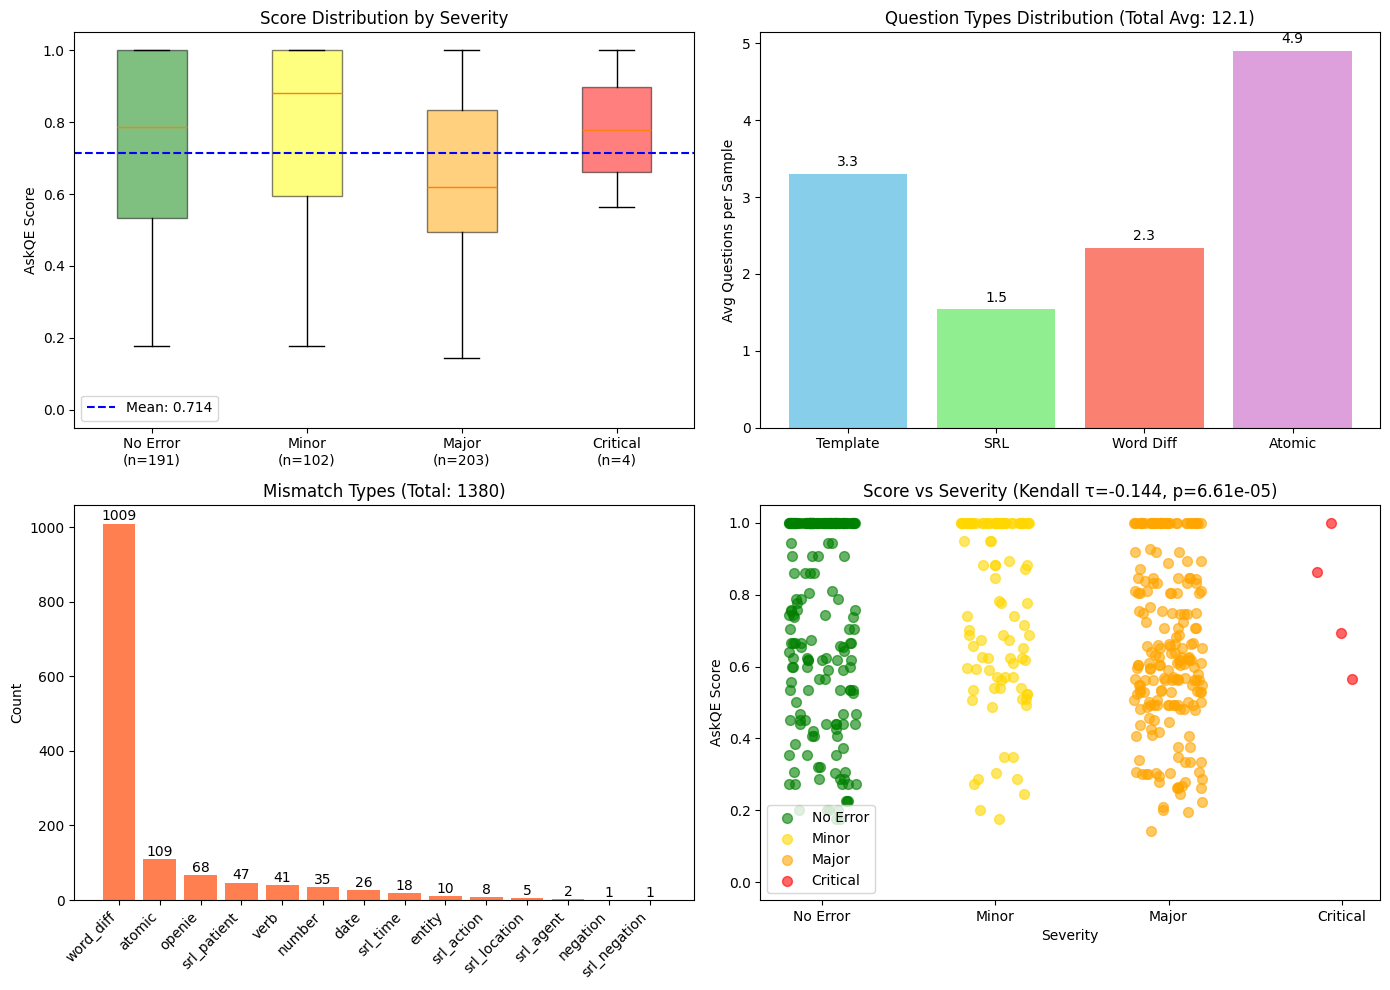

Figure saved to results_visualization.png

MISMATCH ANALYSIS BY SEVERITY
type      atomic  date  entity  negation  number  openie  srl_action  \
severity                                                               
Critical       0     0       0         0       0       0           0   
Major         33    11       8         0      17      43           6   
Minor         15     3       2         0       8      11           1   
No Error      61    12       0         1      10      14           1   

type      srl_agent  srl_location  srl_negation  srl_patient  srl_time  verb  \
severity                                                                       
Critical          0             0             0            0         0     0   
Major             0             2             0           22         5    20   
Minor             0             0             0            9         7     8   
No Error          2             3             1           16         6    13   

type      wor

In [ ]:
import matplotlib.pyplot as plt

# Use valid data only
df_plot = df_valid.copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Score by Severity (Box Plot)
ax1 = axes[0, 0]
severity_groups = []
severity_labels = []
for sev in ["No Error", "Minor", "Major", "Critical"]:
    data = df_plot[df_plot["severity"] == sev]["askqe_score"].dropna()
    if len(data) > 0:
        severity_groups.append(data)
        severity_labels.append(f"{sev}\n(n={len(data)})")

if severity_groups:
    bp = ax1.boxplot(severity_groups, tick_labels=severity_labels, patch_artist=True)
    colors = ['green', 'yellow', 'orange', 'red']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)

ax1.set_ylabel("AskQE Score")
ax1.set_title("Score Distribution by Severity")
ax1.axhline(y=df_plot["askqe_score"].mean(), color='blue', linestyle='--', label=f'Mean: {df_plot["askqe_score"].mean():.3f}')
ax1.legend()
ax1.set_ylim(-0.05, 1.05)

# 2. Questions Distribution by Type
ax2 = axes[0, 1]
question_types = ['num_template_qs', 'num_srl_qs', 'num_diff_qs', 'num_atomic_qs']
question_labels = ['Template', 'SRL', 'Word Diff', 'Atomic']
question_means = [df_plot[qt].mean() for qt in question_types]

bars = ax2.bar(question_labels, question_means, color=['skyblue', 'lightgreen', 'salmon', 'plum'])
ax2.set_ylabel("Avg Questions per Sample")
ax2.set_title(f"Question Types Distribution (Total Avg: {df_plot['num_questions'].mean():.1f})")
for bar, val in zip(bars, question_means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.1f}', ha='center')

# 3. Mismatch Types
ax3 = axes[1, 0]
all_mismatches = []
for r in results:
    if r["askqe_score"] is not None:
        for m in r.get("mismatches", []):
            all_mismatches.append(m)

if all_mismatches:
    mismatch_df = pd.DataFrame(all_mismatches)
    mismatch_counts = mismatch_df["type"].value_counts()
    bars = ax3.bar(mismatch_counts.index, mismatch_counts.values, color="coral")
    ax3.set_title(f"Mismatch Types (Total: {len(all_mismatches)})")
    ax3.set_ylabel("Count")
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

    for bar, count in zip(bars, mismatch_counts.values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom')
else:
    ax3.text(0.5, 0.5, "No mismatches found", ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title("Mismatch Types")

# 4. Score vs Severity (Scatter with jitter)
ax4 = axes[1, 1]
severity_to_num = {"No Error": 0, "Minor": 1, "Major": 2, "Critical": 3}
df_plot["severity_num"] = df_plot["severity"].astype(str).map(severity_to_num)

np.random.seed(42)
jitter = np.random.uniform(-0.2, 0.2, len(df_plot))

colors_map = {"No Error": "green", "Minor": "gold", "Major": "orange", "Critical": "red"}
for sev in ["No Error", "Minor", "Major", "Critical"]:
    mask = df_plot["severity"].astype(str) == sev
    if mask.any():
        x_vals = df_plot.loc[mask, "severity_num"].values + jitter[mask.values]
        y_vals = df_plot.loc[mask, "askqe_score"].values
        ax4.scatter(x_vals, y_vals, c=colors_map[sev], label=sev, alpha=0.6, s=50)

ax4.set_xticks([0, 1, 2, 3])
ax4.set_xticklabels(["No Error", "Minor", "Major", "Critical"])
ax4.set_xlabel("Severity")
ax4.set_ylabel("AskQE Score")
ax4.set_title(f"Score vs Severity (Kendall τ={tau_sev:.3f}, p={p_tau_sev:.2e})")
ax4.legend(loc='lower left')
ax4.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.savefig("results_visualization.png", dpi=150)
plt.show()

print("Figure saved to results_visualization.png")

# Mismatch analysis by severity
print("\n" + "="*60)
print("MISMATCH ANALYSIS BY SEVERITY")
print("="*60)

if all_mismatches:
    mismatch_with_sev = []
    for r in results:
        if r["askqe_score"] is not None:
            for m in r.get("mismatches", []):
                m_copy = m.copy()
                m_copy["severity"] = r["severity"]
                mismatch_with_sev.append(m_copy)

    if mismatch_with_sev:
        mismatch_sev_df = pd.DataFrame(mismatch_with_sev)
        print(mismatch_sev_df.groupby(["severity", "type"]).size().unstack(fill_value=0))
else:
    print("No mismatches found")

# Worst samples
print("\n" + "="*60)
print("WORST SCORE SAMPLES")
print("="*60)

worst = df_valid.nsmallest(5, "askqe_score")
for _, row in worst.iterrows():
    print(f"\nID: {row['id']} | Severity: {row['severity']} | Score: {row['askqe_score']:.3f}")
    print(f"   Questions: {row['num_questions']} (Template: {row['num_template_qs']}, SRL: {row['num_srl_qs']}, Diff: {row['num_diff_qs']}, Atomic: {row['num_atomic_qs']})")
    print(f"   Mismatches: {row['num_mismatches']}")
    print(f"   Source: {row['source'][:80]}...")
    print(f"   BT: {row['backtranslation'][:80]}...")

##10.3 Comprehensive Metrics

In [ ]:
from scipy.stats import pearsonr, kendalltau, spearmanr
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np


print("="*60)
print("COMPREHENSIVE METRICS ANALYSIS")
print("="*60)


# Use valid data
df_metrics = df_valid.copy()


# Create numeric severity
severity_to_num = {"No Error": 0, "Minor": 1, "Major": 2, "Critical": 3}
df_metrics["severity_num"] = df_metrics["severity"].astype(str).map(severity_to_num)


# ============================================
# 1. ALL CORRELATION METRICS
# ============================================
print("\n" + "-"*60)
print("1. CORRELATION METRICS")
print("-"*60)


# vs Severity (higher severity = worse)
tau_sev, p_tau = kendalltau(df_metrics["severity_num"], df_metrics["askqe_score"])
rho_sev, p_rho = spearmanr(df_metrics["severity_num"], df_metrics["askqe_score"])
pear_sev, p_pear = pearsonr(df_metrics["severity_num"], df_metrics["askqe_score"])


print(f"\nCorrelation with Severity (expected: NEGATIVE)")
print(f"   Kendall's tau:  {tau_sev:.4f} (p={p_tau:.2e})")
print(f"   Spearman rho:   {rho_sev:.4f} (p={p_rho:.2e})")
print(f"   Pearson r:      {pear_sev:.4f} (p={p_pear:.2e})")


# vs MQM Score
tau_mqm, p_tau_m = kendalltau(df_metrics["mqm_score"], df_metrics["askqe_score"])
rho_mqm, p_rho_m = spearmanr(df_metrics["mqm_score"], df_metrics["askqe_score"])


print(f"\nCorrelation with MQM Score (expected: POSITIVE)")
print(f"   Kendall's tau:  {tau_mqm:.4f} (p={p_tau_m:.2e})")
print(f"   Spearman rho:   {rho_mqm:.4f} (p={p_rho_m:.2e})")


# ============================================
# 2. DECISION ACCURACY (GMM-based)
# ============================================
print("\n" + "-"*60)
print("2. DECISION ACCURACY (GMM-based)")
print("-"*60)


# Ground truth: Accept = No Error/Minor, Reject = Major/Critical
df_metrics["human_decision"] = df_metrics["severity"].astype(str).apply(
    lambda x: 1 if x in ["No Error", "Minor"] else 0  # 1=Accept, 0=Reject
)


# GMM clustering
X = df_metrics["askqe_score"].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X)
labels = gmm.predict(X)


# Identify Accept cluster (higher mean score)
means = gmm.means_.flatten()
accept_label = np.argmax(means)
df_metrics["predicted_decision"] = (labels == accept_label).astype(int)


# Calculate accuracy
decision_accuracy = accuracy_score(df_metrics["human_decision"], df_metrics["predicted_decision"])
print(f"\nGMM Decision Accuracy: {decision_accuracy*100:.2f}%")


# Confusion matrix
cm = confusion_matrix(df_metrics["human_decision"], df_metrics["predicted_decision"])
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                 Reject  Accept")
print(f"   Actual Reject   {cm[0,0]:4d}    {cm[0,1]:4d}")
print(f"   Actual Accept   {cm[1,0]:4d}    {cm[1,1]:4d}")


# ============================================
# 3. BINARY CLASSIFICATION METRICS
# ============================================
print("\n" + "-"*60)
print("3. BINARY CLASSIFICATION (Error Detection)")
print("-"*60)


# Binary: Has Error (Major/Critical) vs No/Minor Error
df_metrics["has_serious_error"] = df_metrics["severity"].astype(str).apply(
    lambda x: 1 if x in ["Major", "Critical"] else 0
)


# Find optimal threshold
thresholds = np.arange(0.5, 1.0, 0.05)
best_f1 = 0
best_threshold = 0.5


for thresh in thresholds:
    pred = (df_metrics["askqe_score"] < thresh).astype(int)  # Low score = error
    f1_val = f1_score(df_metrics["has_serious_error"], pred, zero_division=0)
    if f1_val > best_f1:
        best_f1 = f1_val
        best_threshold = thresh


print(f"\nOptimal Threshold: {best_threshold:.2f}")
print(f"(Scores below this indicate Major/Critical error)")


# Predictions with optimal threshold
df_metrics["predicted_error"] = (df_metrics["askqe_score"] < best_threshold).astype(int)


precision = precision_score(df_metrics["has_serious_error"], df_metrics["predicted_error"], zero_division=0)
recall = recall_score(df_metrics["has_serious_error"], df_metrics["predicted_error"], zero_division=0)
f1_final = f1_score(df_metrics["has_serious_error"], df_metrics["predicted_error"], zero_division=0)


print(f"\nError Detection Performance:")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1_final:.4f}")


# ROC-AUC
try:
    auc = roc_auc_score(df_metrics["has_serious_error"], 1 - df_metrics["askqe_score"])
    print(f"   ROC-AUC:   {auc:.4f}")
except:
    auc = None
    print(f"   ROC-AUC:   N/A")


# ============================================
# 4. PER-SEVERITY ANALYSIS
# ============================================
print("\n" + "-"*60)
print("4. PER-SEVERITY DETECTION RATE")
print("-"*60)


for sev in ["No Error", "Minor", "Major", "Critical"]:
    sev_data = df_metrics[df_metrics["severity"].astype(str) == sev]
    if len(sev_data) > 0:
        detected = (sev_data["askqe_score"] < best_threshold).sum()
        total = len(sev_data)
        rate = detected / total * 100
        print(f"   {sev:12s}: {detected:3d}/{total:3d} detected ({rate:5.1f}%)")


# ============================================
# 5. SUMMARY TABLE
# ============================================
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

# Format AUC string
auc_str = f"{auc:.4f}" if auc is not None else "N/A"

print(f"""
+--------------------------------------------------+
|              METRIC SUMMARY                       |
+--------------------------------------------------+
| Correlation (vs Severity)                         |
|   Kendall tau:        {tau_sev:.4f} (p={p_tau:.2e})    |
|   Spearman rho:       {rho_sev:.4f} (p={p_rho:.2e})    |
+--------------------------------------------------+
| Correlation (vs MQM Score)                        |
|   Kendall tau:        {tau_mqm:.4f} (p={p_tau_m:.2e})    |
+--------------------------------------------------+
| Decision Accuracy (GMM):  {decision_accuracy*100:.1f}%                  |
| Error Detection F1:       {f1_final:.4f}                  |
| ROC-AUC:                  {auc_str}                  |
+--------------------------------------------------+
""")


COMPREHENSIVE METRICS ANALYSIS

------------------------------------------------------------
1. CORRELATION METRICS
------------------------------------------------------------

Correlation with Severity (expected: NEGATIVE)
   Kendall's tau:  -0.1438 (p=6.61e-05)
   Spearman rho:   -0.1758 (p=7.73e-05)
   Pearson r:      -0.1539 (p=5.54e-04)

Correlation with MQM Score (expected: POSITIVE)
   Kendall's tau:  0.1620 (p=1.81e-06)
   Spearman rho:   0.2062 (p=3.32e-06)

------------------------------------------------------------
2. DECISION ACCURACY (GMM-based)
------------------------------------------------------------

GMM Decision Accuracy: 59.20%

Confusion Matrix:
                 Predicted
                 Reject  Accept
   Actual Reject    170      37
   Actual Accept    167     126

------------------------------------------------------------
3. BINARY CLASSIFICATION (Error Detection)
------------------------------------------------------------

Optimal Threshold: 0.90
(Scores 

##10.4 Save Results

In [ ]:
# Save to JSON
output_file = "binary_extension_results.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)
print(f"Results saved to {output_file}")

# Save summary to CSV
summary_df = df_valid[["id", "severity", "mqm_score", "num_template_qs", "num_srl_qs", "num_diff_qs", "num_atomic_qs", "num_questions", "num_mismatches", "askqe_score"]].copy()
summary_df.to_csv("extension_summary.csv", index=False)
print(f"Summary saved to extension_summary.csv")

# Calculate errors_df for summary
errors_df = df_valid[df_valid["askqe_score"] < best_threshold]

# Final Summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"""
Binary QA Extension Pipeline Results:
=====================================
- Total Samples: {len(df_valid)}
- Mean AskQE Score: {df_valid['askqe_score'].mean():.3f}
- Samples with Errors Detected: {len(errors_df)} ({100*len(errors_df)/len(df_valid):.1f}%)
- Avg Questions/Sample: {df_valid['num_questions'].mean():.1f}
  - Template: {df_valid['num_template_qs'].mean():.1f}
  - SRL: {df_valid['num_srl_qs'].mean():.1f}
  - Word Diff: {df_valid['num_diff_qs'].mean():.1f}
  - Atomic: {df_valid['num_atomic_qs'].mean():.1f}

Correlation Metrics:
- Kendall tau (vs Severity): {tau_sev:.4f}
- Kendall tau (vs MQM): {tau_mqm:.4f}

Decision Metrics:
- GMM Decision Accuracy: {decision_accuracy*100:.1f}%
- Error Detection F1: {f1_final:.4f}

Top Mismatch Types:
{mismatch_df['type'].value_counts().head(5).to_string() if all_mismatches else 'None'}
""")

print("\nFiles saved:")
print("  - extension_results.json (full results)")
print("  - extension_summary.csv (summary table)")
print("  - results_visualization.png (plots)")

Results saved to binary_extension_results.json
Summary saved to extension_summary.csv

FINAL SUMMARY

Binary QA Extension Pipeline Results:
- Total Samples: 500
- Mean AskQE Score: 0.714
- Samples with Errors Detected: 323 (64.6%)
- Avg Questions/Sample: 12.1
  - Template: 3.3
  - SRL: 1.5
  - Word Diff: 2.3
  - Atomic: 4.9

Correlation Metrics:
- Kendall tau (vs Severity): -0.1438
- Kendall tau (vs MQM): 0.1620

Decision Metrics:
- GMM Decision Accuracy: 59.2%
- Error Detection F1: 0.6264

Top Mismatch Types:
type
word_diff      1009
atomic          109
openie           68
srl_patient      47
verb             41


Files saved:
  - extension_results.json (full results)
  - extension_summary.csv (summary table)
  - results_visualization.png (plots)
